In [1]:
# import the necessary libraries

import os
import imutils
import time
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
#Reading the path to load the images

directroy = "C:/Users\zeroo/Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/dataset"
Categories = ["with_mask", "without_mask"]

print("loading images")

loading images


In [3]:
#Preparing the Labels and the data

data_imgs = [ ]
labels = [ ]

for category in Categories:
    path = os.path.join(directroy, category)
    for img in os.listdir(path):
        
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data_imgs.append(image)
        labels.append(category)

# Using one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data_imgs = np.array(data_imgs, dtype="float32")
labels = np.array(labels)

C:\Users\zeroo\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
#Spliting data 
X_train, X_test, y_train, y_test = train_test_split(data_imgs, labels,train_size=0.8, stratify=labels, random_state=42)

# construct the training image generator for data augmentation

aug = ImageDataGenerator(
    
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"

)

In [5]:
# loading the MobileNetV2 network, also ensuring the head of fc layer is left off
# We can also use VGG16 model

Base_Model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model

head_m = Base_Model.output
head_m = AveragePooling2D(pool_size=(7, 7))(head_m)
head_m = Flatten(name="flatten")(head_m)
head_m = Dense(128, activation="relu")(head_m)
head_m = Dropout(0.5)(head_m)
head_m = Dense(2, activation="softmax")(head_m)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=Base_Model.input, outputs=head_m)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in Base_Model.layers:
    layer.trainable = False

In [6]:
# print(Base_Model.summary())

In [7]:
# Initializing learning rate, number of epochs to train and batch size and Compiling the model

init_LR  = 1e-4
epochs = 15
batch_size = 32

print(" compiling model")
optimizer = Adam(lr=init_LR, decay=init_LR / epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# train the head of the network
print("training head")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // batch_size,
    epochs=epochs)

# make predictions on the testing set
print("[INFO] evaluating network...")
Mob_pred = model.predict(X_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
Mob_pred = np.argmax(Mob_pred, axis=1)




 compiling model
training head


C:\Users\zeroo\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
95/95 [==============================] - 78s 750ms/step - loss: 0.4373 - accuracy: 0.8349 - val_loss: 0.1671 - val_accuracy: 0.9844
Epoch 2/15
95/95 [==============================] - 63s 662ms/step - loss: 0.1645 - accuracy: 0.9568 - val_loss: 0.0811 - val_accuracy: 0.9935
Epoch 3/15
95/95 [==============================] - 63s 662ms/step - loss: 0.1026 - accuracy: 0.9727 - val_loss: 0.0561 - val_accuracy: 0.9935
Epoch 4/15
95/95 [==============================] - 63s 663ms/step - loss: 0.0817 - accuracy: 0.9786 - val_loss: 0.0460 - val_accuracy: 0.9935
Epoch 5/15
95/95 [==============================] - 63s 660ms/step - loss: 0.0731 - accuracy: 0.9779 - val_loss: 0.0390 - val_accuracy: 0.9935
Epoch 6/15
95/95 [==============================] - 67s 700ms/step - loss: 0.0574 - accuracy: 0.9848 - val_loss: 0.0352 - val_accuracy: 0.9935
Epoch 7/15
95/95 [==============================] - 63s 663ms/step - loss: 0.0518 - accuracy: 0.9855 - val_loss: 0.0325 - val_accuracy: 0.9935

In [8]:
from sklearn.metrics import classification_report

# Printing Classification report to show the perfermorance of the model

print(classification_report(y_test.argmax(axis=1), Mob_pred,
    target_names=lb.classes_))

# Saving the model to disk
print("saving mask detector model...")
# model.save("C:/Users\zeroo/Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/mask_detector.model", save_format="h5")

model.save("C:/Users\zeroo/Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/mask_detector.model",save_format="h5")


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

saving mask detector model...


C:\Users\zeroo\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


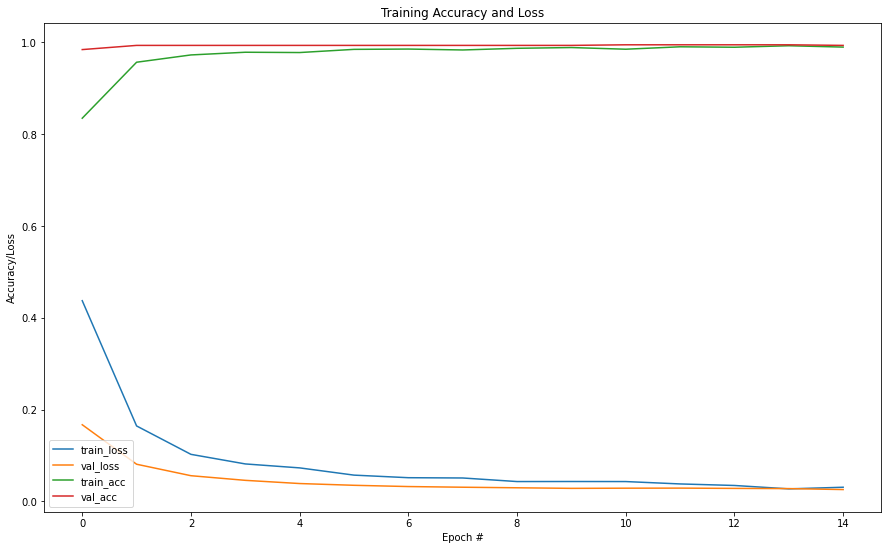

In [12]:
# plot the training loss and accuracy
N = epochs
plt.figure()
plt.rcParams["figure.figsize"] = (13, 8)

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Accuracy and Loss")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [10]:
# Defining a function to detect and predict the mask

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding locations
	return (locs, preds)

In [11]:
# load the serialized face detector model from disk
prototxtPath ="C:/Users/zeroo\Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/face_detector/deploy.prototxt"
weightsPath = "C:/Users\zeroo\Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("C:/Users\zeroo/Desktop/Debi courses/uOttawa/2nd term/Computer vision/Face-Mask-Detection/mask_detector.model")
# initialize the video stream
print("Starting video stream...")
vs = VideoStream(src=0).start()

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

Starting video stream...
(1, 1, 135, 7)
(1, 1, 139, 7)
(1, 1, 140, 7)
(1, 1, 138, 7)
(1, 1, 133, 7)
(1, 1, 142, 7)
(1, 1, 134, 7)
(1, 1, 137, 7)
(1, 1, 133, 7)
(1, 1, 133, 7)
(1, 1, 133, 7)
(1, 1, 143, 7)
(1, 1, 139, 7)
(1, 1, 134, 7)
(1, 1, 142, 7)
(1, 1, 146, 7)
(1, 1, 146, 7)
(1, 1, 143, 7)
(1, 1, 142, 7)
(1, 1, 137, 7)
(1, 1, 140, 7)
(1, 1, 141, 7)
(1, 1, 136, 7)
(1, 1, 141, 7)
(1, 1, 141, 7)
(1, 1, 136, 7)
(1, 1, 136, 7)
(1, 1, 148, 7)
(1, 1, 146, 7)
(1, 1, 145, 7)
(1, 1, 141, 7)
(1, 1, 139, 7)
(1, 1, 139, 7)
(1, 1, 144, 7)
(1, 1, 142, 7)
(1, 1, 141, 7)
(1, 1, 141, 7)
(1, 1, 143, 7)
(1, 1, 142, 7)
(1, 1, 136, 7)
(1, 1, 146, 7)
(1, 1, 144, 7)
(1, 1, 147, 7)
(1, 1, 144, 7)
(1, 1, 136, 7)
(1, 1, 149, 7)
(1, 1, 139, 7)
(1, 1, 149, 7)
(1, 1, 147, 7)
(1, 1, 141, 7)
(1, 1, 146, 7)
(1, 1, 148, 7)
(1, 1, 142, 7)
(1, 1, 152, 7)
(1, 1, 147, 7)
(1, 1, 150, 7)
(1, 1, 149, 7)
(1, 1, 147, 7)
(1, 1, 151, 7)
(1, 1, 144, 7)
(1, 1, 144, 7)
(1, 1, 154, 7)
(1, 1, 151, 7)
(1, 1, 143, 7)
(1, 1, 144, 7)
